# EXERCISE 1 - Regression and Classification

Denis Blessing denis.blessing@kit.edu. This homework has a total of 18 points.

## Submission Instructions
Please follow the instruction from homework ZERO! 


## 1.) Linear Regression (8 Points in Total)

### 1.1) Matrix Vector Calculus (1 Point)
Given the following element-wise expression of a matrix-vector product,
rewrite it in matrix form:

\begin{align*}
        g = \alpha \sum_i \sum_j \sum_k z_k x_{ij} q_i y_{jk}
\end{align*}

![](ex1.1.png)

### 1.2) Derive Ridge Regression Weights (4 Points)
Derive the optimal solution of weights in Ridge Regression using matrix form, i
.e. $\boldsymbol{w}= ?$

**Hint**: You will need derivatives for vectors/matrices. Start
from the matrix objective for ridge regression as stated here

\begin{align*}
L &= (\boldsymbol{y}-\boldsymbol{\Phi} \boldsymbol{w})^T(\boldsymbol{y}-\boldsymbol{\Phi} \boldsymbol{w}) + \lambda \boldsymbol{w}^T \boldsymbol{w}. \\
\end{align*}

**Hint**: It holds that $\boldsymbol{a}^T \boldsymbol{a} = \boldsymbol{a}^T \boldsymbol{I} \boldsymbol{a}$, where $\boldsymbol{I}$ denotes the identity matrix.

![](ex1.2.png)

### Ridge Regression - Code
Let's first get the data


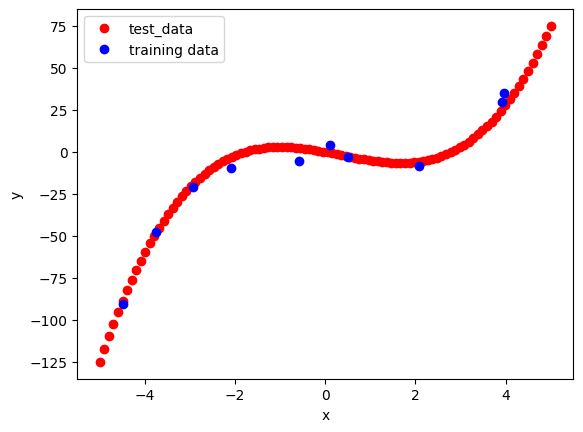

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

# Load data

training_data = np.load('training_data.npy')
test_data = np.load('test_data.npy')

test_data_x = test_data[:, 0]
test_data_y = test_data[:, 1]

training_data_x = training_data[:, 0]
training_data_y = training_data[:, 1]

# Visualize data
plt.plot(test_data_x, test_data_y, 'or')
plt.plot(training_data_x, training_data_y, 'ob')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(["test_data", "training data"])

As in the lecture notebook, we will use polynomial-features here again.
The following functions will be used for:
- calculating polynomial features
- computing the mean and std of the features (training data) as normalizer
- normalize other data (test) features using the normalizer (mean and std)
- evaluating the model
- calculating the Mean Squarred Error for assigning a performance to each
model. <br><br>

Note we will use the mean and the standard deviation to normalize our features
according to:
\begin{align*}
    \boldsymbol{\tilde{\Phi}} = \frac{\boldsymbol{\Phi}(\boldsymbol{x}) - \boldsymbol{\mu}_{\Phi}}{\boldsymbol{\sigma}_{\Phi}}, 
\end{align*}
where $\boldsymbol{\tilde{\Phi}}$ are the (approximately) normalized features to any input
$\boldsymbol{x}$ (not necessarily the training data), $\boldsymbol{\mu}_{\Phi}$ is the mean of the features applied to the training data and $\boldsymbol{\sigma}_{\Phi}$ is the standard deviation of the features applied to the training data for each dimension.<br>

Normalization is a standard technique used in Regression to avoid numerical problems and to obtain better fits for the weight vectors $\boldsymbol{w}$. Especially when the features transform the inputs to a very high value range, normalization is very useful. In this homework we will use features of degree 10. Since the input range of the data is roughly from -4 to 4 this will lead to very high values for higher order degrees. By normalizing each dimension of the feature matrix, we will map each dimension of the feature matrix applied to the training data to a zero mean unit variance distribution.

In [2]:
def get_polynomial_features(data: np.ndarray,
                            degree: int) ->np.ndarray:
    """
    Function to create Feature Matrix. Extends the feature matrix according to
    the matrix form discussed in the lectures.

    :param data: data points you want to evaluate the polynomials,
                 shape: [n_samples] (we have 1-dim data)
    :param degree: degree of your polynomial, shape: scalar
    :return polynomial_features: shape [n_samples x (degree+1)]
    """
    polynomial_features = np.ones(data.shape)
    for i in range(degree):
        polynomial_features = np.column_stack((polynomial_features, data ** (i + 1)))
    return polynomial_features


def get_mean_std_features(polynomial_features: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Function for calculating the mean and standard deviation of the features
    :param polynomial_features: shape: [n_samples x (degree+1)]
    :return mean_feat: mean vector of the features,
            shape:[1 x (degrees+1)]
    :return std_feat: standard deviation (for each dimension in feature matrix),
                      shape: [1 x (degrees+1)] 
    """
    mean_feat = np.mean(polynomial_features, axis=0, keepdims=True)
    mean_feat[:, 0] = 0.0 # we don't want to normalize the bias
    std_feat = np.std(polynomial_features, axis=0, keepdims=True)
    std_feat[:, 0] = 1.0 # we don't want to normalize the bias
    return mean_feat, std_feat


def normalize_features(polynomial_features: np.ndarray,
                       mean_train_features: np.ndarray,
                       std_train_features: np.ndarray) ->np.ndarray:
    """
    Normalize features
    :param polynomial_features:  features to be normalized,
                 shape: [n_samples x (degree+1)]
    :param mean_train_features: mean of the feature matrix of the training set,
                 shape: [1 x (degrees+1)]
    :param std_train_features: std of the feature matrix of the training set,
                 shape: [1 x (degrees+1)]
    :return norm_feat: normalized features, shape: [n_samples x (degree+1)]
    """

    # note: features: (n_samples x n_dims),
    #       mean_train_features: (1 x n_dims),
    #       std_train_features:  (1 x n_dims)
    #       due to these dimensionalities we can do element-wise operations.
    #       By this we normalize each dimension independently
    norm_feat = (polynomial_features - mean_train_features) / std_train_features
    return norm_feat


def eval(Phi:np.ndarray, w:np.ndarray)->np.ndarray:
    """
    Evaluate the models

    :param Phi: Feature matrix, shape: [n_samples x (degree+1)]
    :param w: weight vector, shape: [degree + 1]
    :return : predictions, shape [n_samples] (we have 1-dim data)
    Evaluates your model
    """
    return np.dot(Phi, w)


def mse(y_target:np.ndarray, y_pred:np.ndarray)->np.ndarray:
    """
    :param y_target: the target outputs,
            shape: [n_samples] (here 1-dim data)
    :param y_pred: the predicted outputs,
            shape: [n_samples](we have 1-dim data)
    :return : The Mean Squared Error, shape: scalar
    """
    diff = y_target - y_pred
    return np.sum(diff ** 2, axis=0) / y_pred.shape[0]


### 1.3) Implement Ridge Regression Weights (2 Point)
The following function will calculate the weights for ridge regression. Fill in the missing code according to the formula for calculating the weight updates for ridge regression. <br>
Recall that the formula is given by 
\begin{align*}
    \boldsymbol{w} &= (\boldsymbol{\Phi} ^T \boldsymbol{\Phi} + \lambda \boldsymbol{I} )^{-1} \boldsymbol{\Phi}^T \boldsymbol{y},
\end{align*}
where $\boldsymbol{\Phi}$ is the feature matrix (the matrix storing the data points applied to the polynomial features).
Hint: use np.linalg.solve for solving for the linear equation.
If you got confused because of the normalization described before, don't worry, you do not need to consider it here :)

In [11]:
def calc_weights_ridge(Phi:np.ndarray,
                       y:np.ndarray,
                       ridge_factor:float)->np.ndarray:
    """
    :param Phi: Feature Matrix, shape: [n_samples x (degree+1)]
    :param y: Output Values, [n_samples] (we have 1-dim data)
    :param ridge_factor: lambda value, shape: scalar
    :return : The weight vector, calculated according to the equation shown before,
            shape: [degrees +1]
    """
    ##################
    ##
    lambda_I = np.eye(Phi.shape[1]) * ridge_factor
    A = Phi.T @ Phi + lambda_I
    b = Phi.T @ y

    return np.linalg.solve(A, b)

    #################

For demonstrating ridge regression we will pick the polynomial degree of 10. In the lecture notebook we have seen that this model is highly overfitting to the data.
We will investigate the role of the ridge factor $\lambda$. For that purpose we first need to calculate the weights for different $\lambda$ values. <br>
We will pick $\lambda = [1e-{6}, 1e-{3}, 1, 3, 5,10,20,30,40,50, 1e2, 1e3, 1e5] $ to see the differences of the values. <br><br>

Practical note. We use here very high values for $\lambda$ for demonstration
purposes here. In practice we would not choose a model where we know from
beginning that it is highly overfitting. When choosing an appropriate model, the value needed for $\lambda$ automatically will be small (often in the range of $1e^{-6}$ or smaller).

In [12]:
# Let's do it on polynomial degree 10 and see the results

# first we get the mean and the standard deviation of the training feature matrix, which we will use for normalization
train_features = get_polynomial_features(training_data_x, 10)
test_features = get_polynomial_features(test_data_x, 10)
mean_train_feat, std_train_feat = get_mean_std_features(train_features)
norm_train_features = normalize_features(train_features, mean_train_feat, std_train_feat)
norm_test_features = normalize_features(test_features, mean_train_feat, std_train_feat)


# now we can calculate the normalized features for degree 10
ridge_factors = [1e-6, 1e-3, 1, 3, 5, 10,20,30,40, 50, 1e2, 1e3, 1e5]
weights_ridge = []

for lambda_val in ridge_factors:
    weights_ridge.append(calc_weights_ridge(norm_train_features, training_data_y, lambda_val))

# We further have to perform the predictions based on the models we have calculated
y_training_ridge = []
y_test_ridge = []

for w in weights_ridge:
    y_training_ridge.append(eval(norm_train_features, w))
    y_test_ridge.append(eval(norm_test_features, w))

We are interested in the mean squarred error on the test and the training data. For that purpose we calculate them here and plot the errors for different $\lambda$ values in log space. 

<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_50988/3472932908.py:11: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel("$\lambda$")


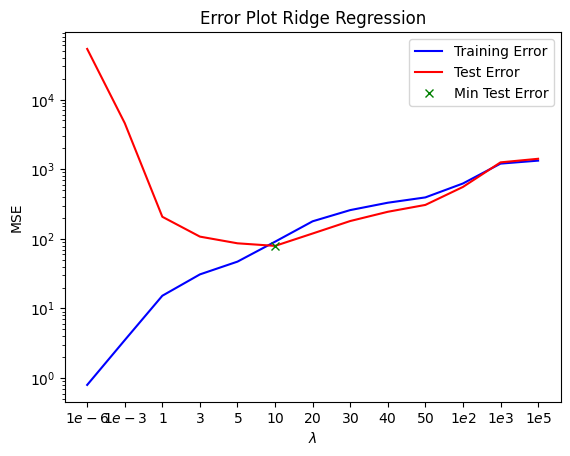

In [13]:
training_error_ridge = []
test_error_ridge = []

for i in range(len(y_training_ridge)):
    training_error_ridge.append(mse(training_data_y, y_training_ridge[i]))
    test_error_ridge.append(mse(test_data_y, y_test_ridge[i]))

error_fig_ridge = plt.figure()
plt.figure(error_fig_ridge.number)
plt.title("Error Plot Ridge Regression")
plt.xlabel("$\lambda$")
plt.ylabel("MSE")
x_axis = ["$1e-{6}$", "$1e-{3}$", "$1$", "$3$", "$5$","$10$","$20$","$30$","$40$","$50$",
          "$1e2$", "$1e3$", "$1e5$"]
plt.yscale('log')
plt.plot(x_axis, training_error_ridge, 'b')
plt.plot(x_axis, test_error_ridge, 'r')
# let's find the index with the minimum training error
min_error_idx = np.argmin(test_error_ridge)
plt.plot(x_axis[min_error_idx], test_error_ridge[min_error_idx], 'xg')
plt.legend(['Training Error', 'Test Error', 'Min Test Error'])


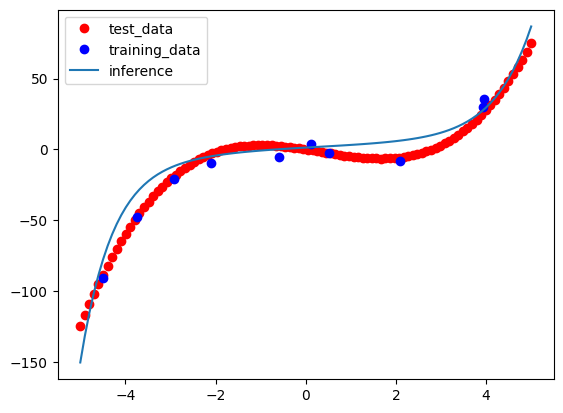

In [14]:
# Let us visualize the newly fitted model with the optimal lambda value here
x = np.linspace(-5, 5, 100)
new_features = get_polynomial_features(x, 10)
new_norm_feat = normalize_features(new_features, mean_train_feat, std_train_feat)
y_pred = eval(new_norm_feat, weights_ridge[min_error_idx])

plt.plot()
plt.plot(test_data_x, test_data_y, 'or')
plt.plot(training_data_x, training_data_y, 'ob')
plt.plot(x, y_pred)
plt.legend(["test_data", "training_data", "inference"])


### 1.4) Error Plot (1 Point)
In the lecture we have seen and analyzed the plot of polynomial degrees 
against the error (slide  39).
Similarly, now please analyze the relationship between the error and the 
different values of $\lambda$, as well as the reason behind it.

Hint: Do not forget that we are in log space. Small changes in the y-axis mean high differences in the error values. <br><br>

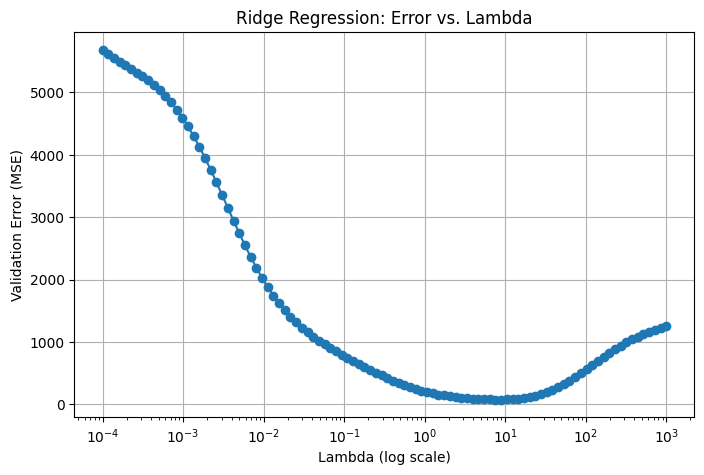

In [18]:
from sklearn.metrics import mean_squared_error

lambdas = np.logspace(-4, 3, 100)
errors = []

for l in lambdas:
    w = calc_weights_ridge(norm_train_features, training_data_y, l)
    y_pred = norm_test_features @ w
    error = mean_squared_error(test_data_y, y_pred)
    errors.append(error)

plt.figure(figsize=(8, 5))
plt.semilogx(lambdas, errors, marker='o')
plt.xlabel('Lambda (log scale)')
plt.ylabel('Validation Error (MSE)')
plt.title('Ridge Regression: Error vs. Lambda')
plt.grid(True)
plt.show()


#### Interpretation
For small $\lambda$ the validation error is very high which is caused by a massive overfitting of the data where the training error is very small.

For $\lambda\approx 10$ the model has a very small validation error. At this point the model is not overfitting with a slightly higher training error. In that case we find the point with a good tradeoff between bias and variance.

For higher $\lambda$ we overfit again and training and test errors are increasing. That is because the model is too easy at this point and some relevant structures in the data is just ignored.

## 2.) Probability Basics and Naive Bayes Classifier (8 Points in Total)

### First Example (Two Moons)

Let us start by loading a very simple toy dataset, the "two moons".

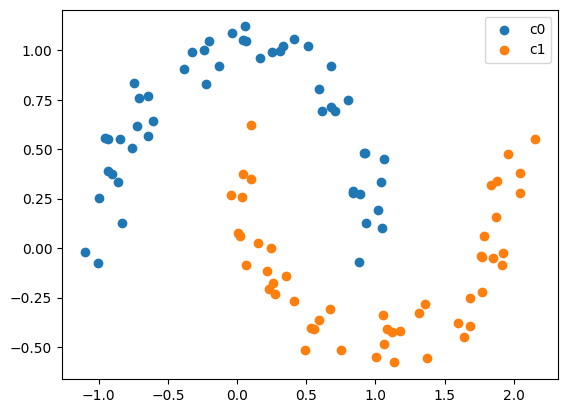

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Callable

data = dict(np.load("two_moons.npz", allow_pickle=True))
samples = data["samples"]
labels = data["labels"]

c0_samples = samples[labels == 0]  # class 0: all samples with label 0
c1_samples = samples[labels == 1]  # class 1: all samples with labe 1

plt.figure("Data")
plt.scatter(x=c0_samples[:, 0], y=c0_samples[:, 1], label="c0")
plt.scatter(x=c1_samples[:, 0], y=c1_samples[:, 1], label="c1")
plt.legend()

Let us also define some plotting utility functions.


In [3]:
def draw_2d_gaussian(mu: np.ndarray, sigma: np.ndarray, plt_std: float = 2, *args, **kwargs) -> None:
    (largest_eigval, smallest_eigval), eigvec = np.linalg.eig(sigma)
    phi = -np.arctan2(eigvec[0, 1], eigvec[0, 0])

    plt.scatter(mu[0:1], mu[1:2], marker="x", *args, **kwargs)

    a = plt_std * np.sqrt(largest_eigval)
    b = plt_std * np.sqrt(smallest_eigval)

    ellipse_x_r = a * np.cos(np.linspace(0, 2 * np.pi, num=200))
    ellipse_y_r = b * np.sin(np.linspace(0, 2 * np.pi, num=200))

    R = np.array([[np.cos(phi), np.sin(phi)], [-np.sin(phi), np.cos(phi)]])
    r_ellipse = np.array([ellipse_x_r, ellipse_y_r]).T @ R
    plt.plot(mu[0] + r_ellipse[:, 0], mu[1] + r_ellipse[:, 1], *args, **kwargs)

# plot grid for contour plots
plt_range = np.arange(-1.5, 2.5, 0.01)
plt_grid = np.stack(np.meshgrid(plt_range, plt_range), axis=-1)
flat_plt_grid = np.reshape(plt_grid, [-1, 2])
plt_grid_shape = plt_grid.shape[:2]

### Classification using Generative Models (Naive Bayes Classifier)

We first try a generative approach, the Naive Bayes Classifier.
We model the class conditional distributions $p(\boldsymbol{x}|c)$ as Gaussians, the class prior $p(c)$ as
Bernoulli and apply Bayes rule to compute the class posterior $p(c|\boldsymbol{x})$.

As a small recap, recall that the density of the Multivariate Normal Distribution is given by

$$ p(\boldsymbol{x}) = \mathcal{N}\left(\boldsymbol{x} | \boldsymbol{\mu}, \boldsymbol{\Sigma} \right) = \dfrac{1}{\sqrt{\det \left(2 \pi \boldsymbol{\Sigma}\right)}} \exp\left( - \dfrac{(\boldsymbol{x}-\boldsymbol{\mu})^T \boldsymbol{\Sigma}^{-1} (\boldsymbol{x}-\boldsymbol{\mu})}{2}\right) $$


In [4]:
def mvn_pdf(x: np.ndarray, mu: np.ndarray, sigma: np.ndarray) -> np.ndarray:
    """
    Density of the Multivariate Normal Distribution
    :param x: samples, shape: [N x dimension]
    :param mu: mean, shape: [dimension]
    :param sigma: covariance, shape: [dimension x dimension]
    :return p(x) with p(x) = N(mu, sigma) , shape: [N]
    """
    norm_term = 1 / np.sqrt(np.linalg.det(2 * np.pi * sigma))
    diff = x - np.atleast_2d(mu)
    exp_term = np.sum(np.linalg.solve(sigma, diff.T).T * diff, axis=-1)
    return norm_term * np.exp(-0.5 * exp_term)

**Practical Aspect:** In practice you would never implement it like that, but stay
in the log-domain. Also for numerically stable implementations of the multivariate normal density the symmetry and
positive definitness of the covariance should be exploited by working with it's Cholesky decomposition $L$, which is a lower triangler matrix.
$$ LL^T = \Sigma $$

The maximum likelihood estimator for a Multivariate Normal Distribution is given by
$$ \boldsymbol{\mu} = \dfrac{1}{N} \sum_{i}^N \boldsymbol{x}_i \quad \quad \boldsymbol{\Sigma} = \dfrac{1}{N} \sum_{i}^N (\boldsymbol{x}_i - \boldsymbol{\mu}) (\boldsymbol{x}_i - \boldsymbol{\mu})^T. $$

This time, before we use it, we are going to derive it:

### Exercise 2.1): Derivation of Maximum Likelihood Estimator (5 Points):

Derive the maximum likelihood estimator for Multivariate Normal distributions, given above.
This derivations involves some matrix calculus.
Matrix calculus is a bit like programming, you google the stuff you need and then plug it together in the right order.
Good resources for such rules are the "matrix cookbook" (https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf) and the Wikipdia article about matrix calculus
(https://en.wikipedia.org/wiki/Matrix_calculus ). State all rules you use explicitly
(except the ones given in the hints below).

**Remark** There are different conventions of how to define a gradient (as column-vector or row-vector). This results in different ways to write the Jacobian and thus different, usually transposed, matrix calculus rules:
- In the lecture we define the gradient as column-vector
- In the Wikipedia article this convention is referred to as "Denominator Layout". It also contains a nice explanation of the different conventions for the gourmets among you ;)
- The Matrix Cookbook uses the same convention (gradient as column vector)
- Please also use it here

**Hint** Here are two of those rules that might come in handy

$\dfrac{\partial\log\det(\boldsymbol{X})}{\partial \boldsymbol{X}} = \boldsymbol{X}^{-1}$

$\dfrac{\partial \boldsymbol{x}^T\boldsymbol{A}\boldsymbol{x}}{\partial \boldsymbol{x}} = 2 \boldsymbol{A}\boldsymbol{x}$ for symmetric matrices $\boldsymbol{A}$ (Hint hint: covariance matrices are always
symmetric)

There is one missing to solve the exercise. You need to find it yourself. (Hint hint: Look in the matrix cookbook, chapter 2.2)

**Answer:**

![](ex2.1.1.png)
![](ex2.1.2.jpg)


**Implementation**

We use the final results from the derivation

In [5]:
def mvn_mle(x: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Maximum Likelihood Estimation of parameters for Multivariate Normal Distribution
    :param x: samples shape: [N x dimension]
    :return mean (shape: [dimension]) und covariance (shape: [dimension x dimension]) that maximize likelihood of data.
    """
    mean = 1 / x.shape[0] * np.sum(x, axis=0)
    diff = x - mean
    cov = 1 / x.shape[0] * diff.T @ diff
    return mean, cov


We can now use this maximum likelihood estimator to fit generative models to the samples of both classes. Using those models and some basic rules of probability we can obtain the class conditional distribution $p(c|\boldsymbol{x})$

### Exercise 2.2) Generative Classifier (2 Points)

Given a way to fit the class conditional using our Maximum Likelihood estimator, we can implement the generative classifier

In [6]:
# Fit Gaussian Distributions using the maximum likelihood estimator to samples from both classes
mu_c0, sigma_c0 = mvn_mle(c0_samples)
mu_c1, sigma_c1 = mvn_mle(c1_samples)

# Prior obtained by "counting" samples in each class
p_c0 = c0_samples.shape[0] / samples.shape[0]
# LEAVE AS EXERCISE
p_c1 = c1_samples.shape[0] / samples.shape[0]  # = 1 - p_c0

def compute_posterior(
        samples: np.ndarray,
        p_c0: float, mu_c0: np.ndarray, sigma_c0: np.ndarray,
        p_c1: float, mu_c1: np.ndarray, sigma_c1: np.ndarray) \
        -> Tuple[np.ndarray, np.ndarray]:
    """
    computes the posteroir distribution p(c|x) given samples x, the prior p(c) and the
    class conditional likelihood p(x|c)
    :param samples: samples x to classify, shape: [N x dimension]
    :param p_c0: prior probability of class 0, p(c=0)
    :param mu_c0: mean of class conditional likelihood of class 0, p(x|c=0) shape: [dimension]
    :param sigma_c0: covariance of class conditional likelihood of class 0, p(x|c=0) shape: [dimension x dimension]
    :param p_c1: prior probability of class 1 p(c=1)
    :param mu_c1: mean of class conditional likelihood of class 1 p(x|c=1) shape: [dimension]
    :param sigma_c1: covariance of class conditional likelihood of class 1, p(x|c=1) shape: [dimension x dimension]
    :return two arrays, p(c=0|x) and p(c=1|x), both shape [N]
    """

    likelihood_c0 = mvn_pdf(samples, mu_c0, sigma_c0)
    likelihood_c1 = mvn_pdf(samples, mu_c1, sigma_c1)

    unnorm_0 = likelihood_c0 * p_c0
    unnorm_1 = likelihood_c1 * p_c1

    evidence = unnorm_0 + unnorm_1

    p_c0_given_x = unnorm_0 / evidence
    
    return p_c0_given_x, 1 - p_c0_given_x


p_c0_given_x, p_c1_given_x = compute_posterior(samples, p_c0, mu_c0, sigma_c0, p_c1, mu_c1, sigma_c1)
# Prediction
predicted_labels = np.zeros(labels.shape)
# break at 0.5 arbitrary
predicted_labels[p_c0_given_x >= 0.5] = 0.0  # is not strictly necessary since whole array already zero.
predicted_labels[p_c1_given_x > 0.5] = 1.0

# Evaluate
acc = (np.count_nonzero(predicted_labels == labels)) / labels.shape[0]
print("Accuracy:", acc)

Accuracy: 0.87


Lets look at the class likelihoods


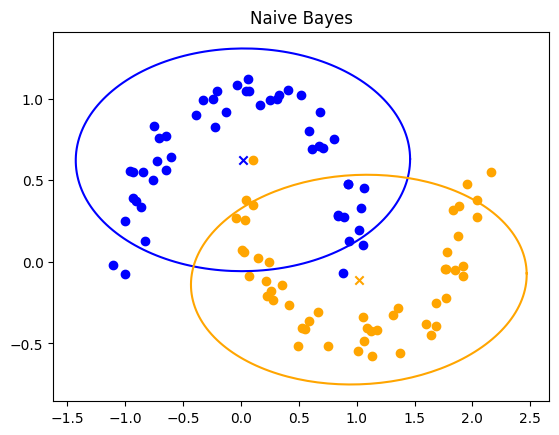

In [7]:
plt.title("Naive Bayes")
plt.scatter(x=samples[labels == 0, 0], y=samples[labels == 0, 1], c="blue")
draw_2d_gaussian(mu_c0, sigma_c0, c="blue")
plt.scatter(x=samples[labels == 1, 0], y=samples[labels == 1, 1], c="orange")
draw_2d_gaussian(mu_c1, sigma_c1, c="orange")

And the final posterior distribution for the case $p(c=1|\boldsymbol{x})$


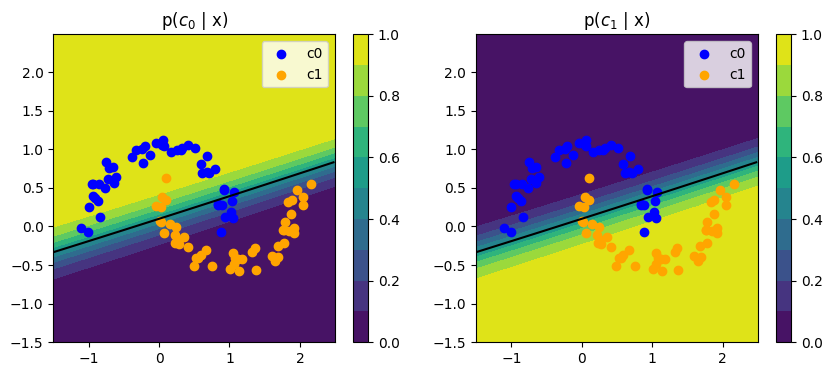

In [8]:
p_c0_given_x, p_c1_given_x = compute_posterior(flat_plt_grid, p_c0, mu_c0, sigma_c0, p_c1, mu_c1, sigma_c1)
p_c0_given_x = np.reshape(p_c0_given_x, plt_grid_shape)
p_c1_given_x = np.reshape(p_c1_given_x, plt_grid_shape)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.contourf(plt_grid[..., 0], plt_grid[..., 1], p_c0_given_x, levels=10)
plt.colorbar()
# plot decision boundary
plt.contour(plt_grid[..., 0], plt_grid[..., 1], p_c0_given_x, levels=[0.0, 0.5], colors=["k", "k"])

plt.title("p($c_0$ | x)")
s0 = plt.scatter(c0_samples[..., 0], c0_samples[..., 1], color="blue")
s1 = plt.scatter(c1_samples[..., 0], c1_samples[..., 1], color="orange")
plt.legend([s0, s1], ["c0", "c1"])
plt.xlim(-1.5, 2.5)

plt.subplot(1, 2, 2)
plt.contourf(plt_grid[..., 0], plt_grid[..., 1], p_c1_given_x, levels=10)
plt.colorbar()
# plot decision boundary
plt.contour(plt_grid[..., 0], plt_grid[..., 1], p_c0_given_x, levels=[0.0, 0.5], colors=["k", "k"])
plt.title("p($c_1$ | x)")
s0 = plt.scatter(c0_samples[..., 0], c0_samples[..., 1], color="blue")
s1 = plt.scatter(c1_samples[..., 0], c1_samples[..., 1], color="orange")
plt.legend([s0, s1], ["c0", "c1"])

plt.xlim(-1.5, 2.5)
plt.show()

The color indicates the posterior likelihood for the respective call and the black line indicates the decision boundary.
We achieve a train accuracy of 87%.
For such a simple task that is clearly not great, but it nicely illustrates a
problem with generative approaches:
They usually depend on quite a lot of assumptions.

### Exercise 2.3) Wrong Assumptions? (1 Point):
Which untrue assumption did we make?

**Answer**

TODO


## 3) Batch Gradient Descent (2 Points in Total)

In the recap sessions with Prof. Neumann we already saw (or will see) an implementation of a Discriminative Classifier using Logistic Regression. Here we are going to extend this to batch gradient descent.

We start by implementing a few helper functions for affine mappings, the sigmoid function, and the negative Bernoulli log-likelihood.

In [9]:
def affine_features(x: np.ndarray) -> np.ndarray:
    """
    implements affine feature function
    :param x: inputs, shape: [N x sample_dim]
    :return inputs with additional bias dimension, shape: [N x feature_dim]
    """
    return np.concatenate([x, np.ones((x.shape[0], 1))], axis=-1)

def quad_features(x: np.ndarray) -> np.ndarray:
    """
    implements quadratic feature function
    :param x: inputs, shape: [N x sample_dim]
    :return squared features of x, shape: [N x feature_dim]
    """
    sq = np.stack([x[:, 0] ** 2, x[:, 1]**2, x[:, 0] * x[:, 1]], axis=-1)
    return np.concatenate([sq, affine_features(x)], axis=-1)

def cubic_features(x: np.ndarray) -> np.ndarray:
    """
    implements cubic feature function
    :param x: inputs, shape: [N x sample_dim]
    :return cubic features of x, shape: [N x feature_dim]
    """
    cubic = np.stack([x[:, 0]**3, x[:, 0]**2 * x[:, 1], x[:, 0] * x[:, 1]**2, x[:, 1]**3], axis=-1)
    return np.concatenate([cubic, quad_features(x)], axis=-1)

def sigmoid(x: np.ndarray) -> np.ndarray:
    """
    the sigmoid function
    :param x: inputs
    :return sigma(x)
    """
    return 1 / (1 + np.exp(-x))

def bernoulli_nll(predictions: np.ndarray, labels: np.ndarray, epsilon: float = 1e-12) -> np.ndarray:
    """
    :param predictions: output of the classifier, shape: [N]
    :param labels: true labels of the samples, shape: [N]
    :param epsilon: small offset to avoid numerical instabilities (i.e log(0))
    :return negative log-likelihood of the labels given the predictions
    """
    return - (labels * np.log(predictions + epsilon) + (1 - labels) * np.log(1 - predictions + epsilon))

We are also using the same bernoulli objective and its gradient as before

In [10]:
def objective_bern(weights: np.ndarray, features: np.ndarray, labels: np.ndarray) -> float:
    """
    bernoulli log-likelihood objective
    :param weights: current weights to evaluate, shape: [feature_dim]
    :param features: train samples, shape: [N x feature_dim]
    :param labels: class labels corresponding to train samples, shape: [N]
    :return average negative log-likelihood
    """
    predictions = sigmoid(features @ weights)
    return np.mean(bernoulli_nll(predictions, labels))

def d_objective_bern(weights: np.ndarray, features: np.ndarray, labels: np.ndarray) -> np.ndarray:
    """
    gradient of the bernoulli log-likelihood objective
    :param weights: current weights to evaluate, shape: [feature_dim]
    :param features: train samples, shape: [N x feature_dim]
    :param labels: class labels corresponding to train samples, shape [N]
    """
    res = np.expand_dims(sigmoid(features @ weights) - labels, -1)
    grad = features.T @ res / res.shape[0]
    return np.squeeze(grad)

### Exercise 3.1) Implementation (2 Points)

Finally, we can implement our batch gradient descent optimizer.

In [12]:
def minimize_with_gradient_descent(features: np.ndarray, labels: np.ndarray, initial_weights: np.ndarray, schedule: Callable,
                      num_iterations: int):
    """
    :param features: all samples, shape: [N x feature_dim]
    :param labels: all labels, shape: [N]
    :param initial_weights: initial weights of the classifier, shape: [feature_dim * K]
    :param schedule: learning rate schedule (a callable function returning the learning rate, given the iteration
    :param num_iterations: number of times to loop over the whole dataset
    return "argmin", "min", logging info
    """


    # setup
    weights = np.zeros([num_iterations + 1, initial_weights.shape[0]])
    loss = np.zeros(num_iterations + 1)
    weights[0] = initial_weights
    loss[0]= objective_bern(weights[0], features, labels)

    for i in range(num_iterations):
        # get learning rate and perform batch gradient descent step
        learning_rate = schedule(i)

        gradient = d_objective_bern(weights[i], features, labels)

        weights[i+1] = weights[i] - learning_rate * gradient

        # log loss (on all samples, usually you should not use all samples to evaluate after each update step)
        loss[i + 1] = objective_bern(weights[i + 1], features, labels)

    return weights[-1], loss[-1], (weights, loss)

Final loss 0.019965117855794676


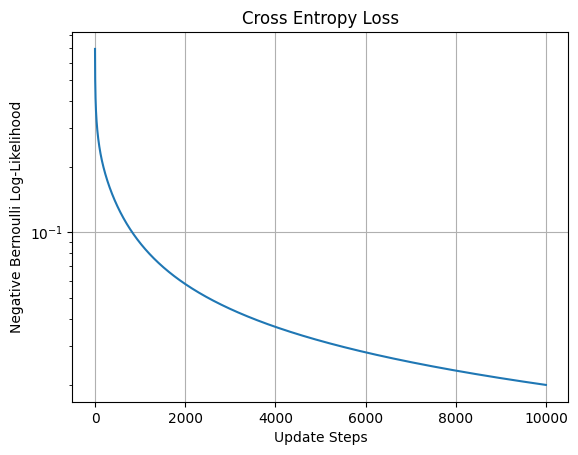

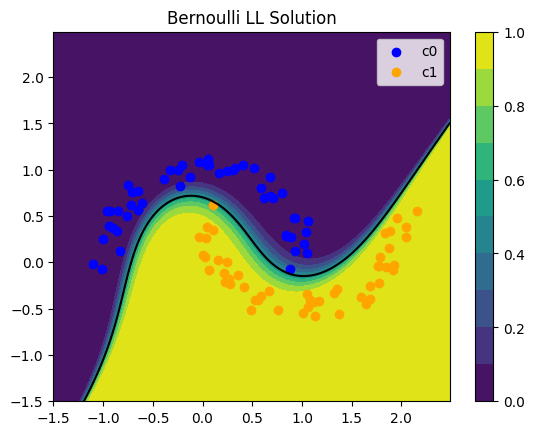

In [13]:
# Generate Features from Data

# change this to play arround with feature functions
#feature_fn = affine_features
#feature_fn = quad_features
feature_fn = cubic_features
features = feature_fn(samples)

num_iterations = 10000

w_bce, l, l_info = minimize_with_gradient_descent(features, labels, np.zeros(features.shape[1]),
                                 schedule=(lambda t: 0.25),
                                 num_iterations=num_iterations)
print("Final loss", l)

plt.figure()
plt.title("Cross Entropy Loss")
plt.grid("on")
plt.xlabel("Update Steps")
plt.ylabel("Negative Bernoulli Log-Likelihood")
plt.semilogy(l_info[1])

plt.figure()
plt.title("Bernoulli LL Solution")
pred_grid = np.reshape(sigmoid(feature_fn(flat_plt_grid) @ w_bce), plt_grid_shape)

plt.contourf(plt_grid[..., 0], plt_grid[..., 1], pred_grid, levels=10)
plt.colorbar()
#This is just a very hacky way to get a black line at the decision boundary:
plt.contour(plt_grid[..., 0], plt_grid[..., 1], pred_grid, levels=[0, 0.5], colors=["k"])

s0 = plt.scatter(c0_samples[..., 0], c0_samples[..., 1], color="blue")
s1 = plt.scatter(c1_samples[..., 0], c1_samples[..., 1], color="orange")
plt.legend([s0, s1], ["c0", "c1"])